<a href="https://colab.research.google.com/github/aiahsaniqbal/Chatbot/blob/main/ai_test_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Test

Goal: to detect and classify two types of beads from the images.
- We call the beads "live" and "dead" beads as they simulate live and dead cells. The "live" beads are bigger than "dead" beads.
- The label images (i.e. masks) have two channels, with channel 0 = live and 1 = dead.
- Each object in a mask is represented by a different pixel value.
- Input image size = 1 x 256 x 256, mask image size = 2 x 256 x 256.

Requirements:
- Your task is to complete this script for training and infering with a MaskRCNN model.
- You'll need a GPU and CUDA to speed up training. You can use your own setup, or use Google Colab.
- No need for hyperparameter tuning, so use train/test split (no validation) is enough.
- There are 2 optional bonus tasks to complete, if you have time.

Tips:
- A helper script `helper.py`, and some example snippets are provided. These will help with completing the script.
- All images are TIFF, which you can open by using `skimage.io` from `scikit-image`.


## Google Colab
If you use Google Colab, you'll need to enable GPUs for the notebook:
1. Navigate to Edit → Notebook Settings
2. Select GPU from the Hardware Accelerator drop-down

You'll also need to upload some files:
1. On the left-hand side bar, choose the folder icon (fourth one down).
2. Select Upload icon (First on the left under the text "Files").
3. Navigate to and select `helper.py`, `data.zip`, then press Open.
4. Run the command `unzip data.zip`.



Copyright © 2021 Solentim Ltd.

In [1]:
# unzip data
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/input/
  inflating: data/input/bead_001.tif  
  inflating: data/input/bead_002.tif  
  inflating: data/input/bead_003.tif  
  inflating: data/input/bead_004.tif  
  inflating: data/input/bead_005.tif  
  inflating: data/input/bead_006.tif  
  inflating: data/input/bead_007.tif  
  inflating: data/input/bead_008.tif  
  inflating: data/input/bead_009.tif  
  inflating: data/input/bead_010.tif  
  inflating: data/input/bead_011.tif  
  inflating: data/input/bead_012.tif  
   creating: data/mask/
  inflating: data/mask/bead_001.tif  
  inflating: data/mask/bead_002.tif  
  inflating: data/mask/bead_003.tif  
  inflating: data/mask/bead_004.tif  
  inflating: data/mask/bead_005.tif  
  inflating: data/mask/bead_006.tif  
  inflating: data/mask/bead_007.tif  
  inflating: data/mask/bead_008.tif  
  inflating: data/mask/bead_009.tif  
  inflating: data/mask/bead_010.tif  
  inflating: data/mask/bead_011.tif  
  inflating: data/mask/bead

In [2]:
# install modules
!pip install numpy scipy scikit-image torch matplotlib torchvision

## Import modules

In [3]:
import os
import math
import numpy as np
from skimage import io
import torch
from matplotlib import pyplot as plt

import helper

# choose CPU or GPU here
# TORCH_DEVICE = 'cpu'
TORCH_DEVICE = 'cuda:0'

## Example snippets

### Example images

Input shape: (256, 256)
Mask shape: (2, 256, 256)


Text(0.5, 1.0, 'Mask channel 1 (dead)')

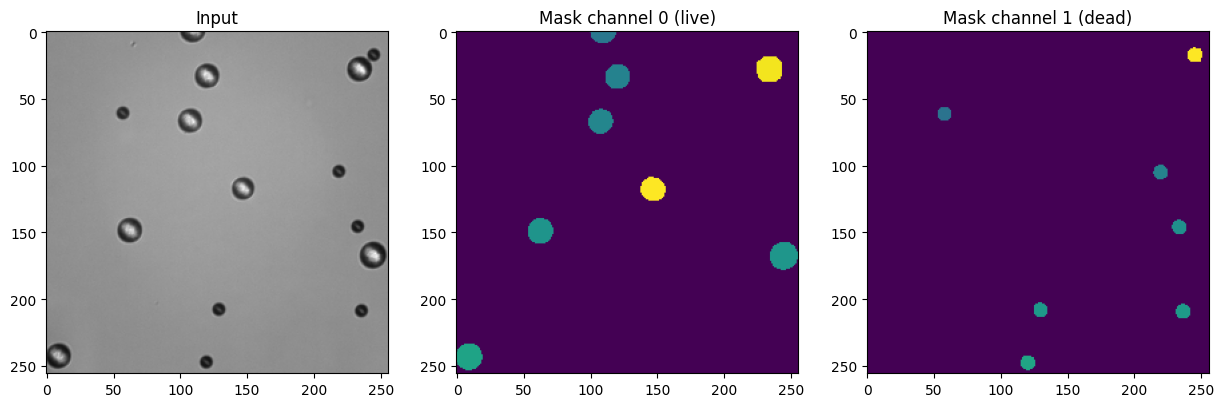

In [4]:
example_input = io.imread('./data/input/bead_002.tif')
example_mask  = io.imread('./data/mask/bead_002.tif')

print(f'Input shape: {example_input.shape}')
print(f'Mask shape: {example_mask.shape}')

# add a 0th dimension
example_input = np.array([example_input])

# display
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(example_input[0], vmin=0, vmax=255, cmap='gray')
plt.title('Input')

plt.subplot(132)
plt.imshow(example_mask[0])
plt.title('Mask channel 0 (live)')

plt.subplot(133)
plt.imshow(example_mask[1])
plt.title('Mask channel 1 (dead)')

### Convert Numpy array to Torch tensors

Before feeding data into torch model, any image data must satisfy the following:
- Image must have the shape [number_of_samples, channels, height, widths], or
  NCHW for short.
- Pixel values are floating numbers, and must be normalised to the range 0 to 1
  inclusive.

In [5]:
# convert masks into objects needed by torch (pixel values already normalised).
boxes, labels, masks = helper.mask_image_to_instances(example_mask)

print('boxes:', boxes.shape, boxes.dtype)
print('labels:', labels.shape, labels.dtype)
print('masks:', masks.shape, masks.dtype)

# MaskRCNN requires a background class = class 0
# So the labels are offset by 1, i.e. live = 1, dead = 2
print('labels =', labels)


boxes: torch.Size([15, 4]) torch.float32
labels: torch.Size([15]) torch.int64
masks: torch.Size([15, 256, 256]) torch.uint8
labels = tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])


## Load datasets

We need to create data loaders to generate input and mask batches.

Note:
- When using skimage.io.imread to read TIFF image stacks, the output Numpy array usually has the shape `[channel, height, width]`, unless:
  - If the TIFF image has 3 channels: output shape is `[height, width, channel]`.
  - If the TIFF image has only 1 channel: output shape is `[height, width]`.
  
  We need channel-first ordering, i.e. `[channel, height, width]` or CHW for short. CHW is the default ordering used by Pytorch. For single-channel images, we need to add a `channel` axis.

### Define custom dataset class

Complete the following custom data loader class, which was created by inheriting torch.utils.data.Dataset class.

In [6]:
class BeadsDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        """
        Parameters
        ----------
        root : str
          Path to dataset.
        """
        self.root = root

        # Get full file paths for input images and masks
        """
        #############################
        #   COMPLETE THIS SECTION!  #
        #############################
        Task: populate self.input_paths and self.mask_paths with FULL file paths.
        """
        import os

        # Get paths to input and mask directories
        input_dir = os.path.join(root, 'input')
        mask_dir = os.path.join(root, 'mask')

        # Get all TIFF files and sort them to ensure matching pairs
        input_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.tif')])
        mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])

        # Create full file paths
        self.input_paths = [os.path.join(input_dir, f) for f in input_files]
        self.mask_paths = [os.path.join(mask_dir, f) for f in mask_files]

        # Verify we have matching pairs
        assert len(self.input_paths) == len(self.mask_paths), "Mismatch between input and mask files"


    def __getitem__(self, idx):
        """
        Parameters
        ----------
        idx : int
          Input/mask pair index.
        """

        # load inputs and masks
        """
        #############################
        #   COMPLETE THIS SECTION!  #
        #############################
        Task: choose one pair of input_path and mask_path from the path lists
        """
        from skimage import io
        import numpy as np

        # Get the corresponding input and mask paths for this index
        input_path = self.input_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load the image and mask using skimage
        image = io.imread(input_path)
        mask = io.imread(mask_path)


        """
        #############################
        #   COMPLETE THIS SECTION!  #
        #############################
        Task: image and mask should be transformed into the correct shape, dtype and range:
        Note:
            - mask should be of the dtype np.int32
        """
        # Ensure image is in CHW format (Channel, Height, Width)
        if len(image.shape) == 2:  # Single channel grayscale
            image = np.expand_dims(image, axis=0)  # Add channel dimension
        elif len(image.shape) == 3 and image.shape[2] == 3:  # RGB with HWC format
            image = image.transpose(2, 0, 1)  # Convert to CHW

        # Normalize image to [0, 1] range and convert to float32
        image = image.astype(np.float32) / 255.0

        # Ensure mask is in the correct format and dtype
        mask = mask.astype(np.int32)


        # convert numpy arrays into torch tensors
        image = torch.as_tensor(image)
        mask = torch.as_tensor(mask)


        # data augmentation
        """
        #############################
        #        BONUS TASK         #
        #############################
        Task: randomly augment data (e.g. flipping horizontally / vertically,
              rotation).
        """
        # Apply random data augmentations
        if np.random.rand() > 0.5:  # 50% chance of horizontal flip
            image = torch.flip(image, dims=[-1])  # Flip along width axis
            mask = torch.flip(mask, dims=[-1])

        if np.random.rand() > 0.5:  # 50% chance of vertical flip
            image = torch.flip(image, dims=[-2])  # Flip along height axis
            mask = torch.flip(mask, dims=[-2])


        # convert mask into MaskRCNN output objects
        boxes, labels, masks = helper.mask_image_to_instances(mask.numpy()) # Convert mask back to numpy for helper function
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # assume none of the instances is crowd
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target


    def __len__(self):
        return len(self.input_paths)

### Initialise data loaders

Create two data loaders `data_loader_train` and `data_loader_test`.

In [7]:
dataset_root = './data'

def collate_fn(batch):
    return tuple(zip(*batch))

"""
#############################
#   COMPLETE THIS SECTION!  #
#############################
Task: Using the BeadsDataset class, initialize the two dataloaders for the train and the test dataset,
using 80% of the whole dataset for training and 20% of the dataset for testing.
- Note:
      - Use the collate_fn above for the dataloaders

"""
import torch.utils.data

# Create the full dataset
full_dataset = BeadsDataset(dataset_root)

# Calculate split sizes
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

print(f"Total dataset size: {dataset_size}")
print(f"Training size: {train_size}")
print(f"Test size: {test_size}")

# Split the dataset
train_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Create data loaders
batch_size = 2  # Small batch size due to memory constraints
data_loader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0  # Set to 0 to avoid multiprocessing issues in Colab
)

data_loader_test = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

print(f"Train loader has {len(data_loader_train)} batches")
print(f"Test loader has {len(data_loader_test)} batches")


Total dataset size: 12
Training size: 9
Test size: 3
Train loader has 5 batches
Test loader has 3 batches


## Define model

Use `MaskRCNN` model and backbone from `maskrcnn_resnet50_fpn`, both are found in `torchvision.models.detection`.
- Don't use pretrained weights
- Use `num_class=3`, since we have 3 classes (background, live, dead). MaskRCNN requires a background class as class 0.
- Other parameters can be kept as default values.

In [8]:
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection import maskrcnn_resnet50_fpn

num_classes = 3

# define MaskRCNN here, name it as `model`.
"""
#############################
#   COMPLETE THIS SECTION!  #
#############################
Task: define backbone and model.
"""
# Create the backbone using ResNet50 FPN (Feature Pyramid Network)
backbone = maskrcnn_resnet50_fpn(pretrained=False).backbone

# Create the MaskRCNN model
model = MaskRCNN(
    backbone,
    num_classes=num_classes,  # 3 classes: background, live, dead
    # Optional: You can customize other parameters like:
    # rpn_anchor_generator, box_roi_pool, etc.
)


# send model to CUDA
model.to(TORCH_DEVICE)

# construct an optimizer Adam(lr=0.0001)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


In [9]:
print(model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

## Train model

Train the model for 100 epochs (should take about 2 minutes on Colab).

In [10]:
import sys

def train_one_epoch(model, optimizer, data_loader_train, device):
    model.train()

    for images, targets in data_loader_train:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print(f'Loss is {loss_value}, stopping training')
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        return losses

In [11]:
start_epoch = 0
num_epochs = 100
save_epoch_interval = 10

# Initialize loss tracking for bonus task
loss_history = []

"""
#############################
#   COMPLETE THIS SECTION!  #
#############################
Task: during training, the model's weights will be regularly saved into the
      folder "./backup". Create the folder here.
"""
# Create backup directory for saving model weights
import os
backup_dir = './backup'
if not os.path.exists(backup_dir):
    os.makedirs(backup_dir)
    print(f"Created backup directory: {backup_dir}")
else:
    print(f"Backup directory already exists: {backup_dir}")


for epoch in range(start_epoch+1, num_epochs+1):
    print(f'Epoch {epoch}/{num_epochs}', end='')

    losses = train_one_epoch(model, optimizer, data_loader_train, TORCH_DEVICE)
    print(f' losses: {losses:.4f}')


    """
    #############################
    #        BONUS TASK         #
    #############################
    Task: record the losses into a text file, or TensorBoard
    """
    # Record losses to history and save to text file
    loss_history.append(losses.item())

    # Save loss history to text file every 10 epochs
    if epoch % save_epoch_interval == 0:
        with open('./backup/loss_history.txt', 'w') as f:
            f.write("Epoch,Loss\n")
            for i, loss in enumerate(loss_history):
                f.write(f"{i+1},{loss:.6f}\n")


    # save the model regularly
    import datetime
    if epoch > 0 and epoch % save_epoch_interval == 0:
        print(f'Reached epoch {epoch}, saving model...')
        time_now_text = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        save_path = os.path.join('./backup', f'{time_now_text}_epoch-{epoch}')
        torch.save(model.state_dict(), save_path)
        print(f'Model save at {save_path}')


Created backup directory: ./backup
Epoch 1/100 losses: 5.2434
Epoch 2/100 losses: 2.9160
Epoch 3/100 losses: 2.6659
Epoch 4/100 losses: 2.0951
Epoch 5/100 losses: 1.9833
Epoch 6/100 losses: 1.7412
Epoch 7/100 losses: 1.5594
Epoch 8/100 losses: 1.7449
Epoch 9/100 losses: 1.9167
Epoch 10/100 losses: 2.1311
Reached epoch 10, saving model...
Model save at ./backup/2025-09-28_20-44-09_epoch-10
Epoch 11/100 losses: 2.1219
Epoch 12/100 losses: 1.9328
Epoch 13/100 losses: 2.0290
Epoch 14/100 losses: 1.9209
Epoch 15/100 losses: 1.8895
Epoch 16/100 losses: 1.8800
Epoch 17/100 losses: 1.7449
Epoch 18/100 losses: 1.7463
Epoch 19/100 losses: 1.7673
Epoch 20/100 losses: 1.6578
Reached epoch 20, saving model...
Model save at ./backup/2025-09-28_20-44-15_epoch-20
Epoch 21/100 losses: 1.5162
Epoch 22/100 losses: 1.4818
Epoch 23/100 losses: 1.3519
Epoch 24/100 losses: 1.3789
Epoch 25/100 losses: 1.2425
Epoch 26/100 losses: 1.3094
Epoch 27/100 losses: 1.2010
Epoch 28/100 losses: 1.1735
Epoch 29/100 losse

## Inference

Test out the new model,

Hopefully you will get something similar to this at the end:

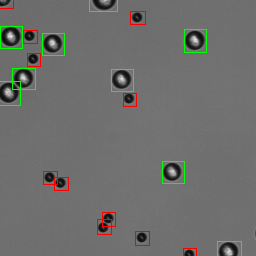


In [12]:
# load from saved weights
"""
#############################
#   COMPLETE THIS SECTION!  #
#############################
Task: reload `model` with the latest saved trained model weights.
Note: this task is here just for the sake of a technical test, of course in this
      case the current model's weight is already the same as the latest saved
      model.
"""
import glob
import os

# Find the latest saved model file
backup_files = glob.glob('./backup/*')
if backup_files:
    # Sort by modification time and get the latest
    latest_model = max(backup_files, key=os.path.getctime)
    print(f"Loading model from: {latest_model}")

    # Load the saved state dict
    model.load_state_dict(torch.load(latest_model, map_location=TORCH_DEVICE))
    print("Model weights loaded successfully!")
else:
    print("No saved model found. Using current model weights.")

# Set model to evaluation mode for inference
model.eval()

Loading model from: ./backup/2025-09-28_20-45-04_epoch-100
Model weights loaded successfully!


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [13]:
# infer on test images (although there is only one image being inferred)
images, targets = next(iter(data_loader_test))
test_images = [image.to(TORCH_DEVICE) for image in images]

pred = model(test_images)

In [14]:
"""
#############################
#   COMPLETE THIS SECTION!  #
#############################
Task: 1. convert Pytorch tensors in `pred` to Numpy arrays.
      2. we used only one image for inference - convert this image into a Numpy
         array as well.
Hint: - inspect pred structure.
      - example snippets.
"""
# Convert predictions from PyTorch tensors to NumPy arrays
# pred is a list containing one dictionary (since we used one image)
pred_dict = pred[0]

# Extract and convert each component to numpy
boxes = pred_dict['boxes'].cpu().detach().numpy()
labels = pred_dict['labels'].cpu().detach().numpy()
scores = pred_dict['scores'].cpu().detach().numpy()
masks = pred_dict['masks'].cpu().detach().numpy()

# Convert the test image to numpy array
image = test_images[0].cpu().detach().numpy()

print(f"Detected {len(boxes)} objects")
print(f"Boxes shape: {boxes.shape}")
print(f"Labels: {labels}")
print(f"Scores: {scores}")
print(f"Masks shape: {masks.shape}")
print(f"Image shape: {image.shape}")

Detected 24 objects
Boxes shape: (24, 4)
Labels: [1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 1 2 2 1 1 1]
Scores: [0.98757964 0.98751837 0.9870176  0.9862997  0.9845344  0.9839236
 0.9621889  0.95909464 0.9588666  0.9578884  0.95509815 0.95455235
 0.9539475  0.9489477  0.945897   0.47554934 0.14170738 0.10645366
 0.09175467 0.08769429 0.08052122 0.0607664  0.05987202 0.05300337]
Masks shape: (24, 1, 256, 256)
Image shape: (1, 256, 256)


Showing 15 detections with score >= 0.9
Filtered scores: [0.98757964 0.98751837 0.9870176  0.9862997  0.9845344  0.9839236
 0.9621889  0.95909464 0.9588666  0.9578884  0.95509815 0.95455235
 0.9539475  0.9489477  0.945897  ]
Filtered labels: [1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]


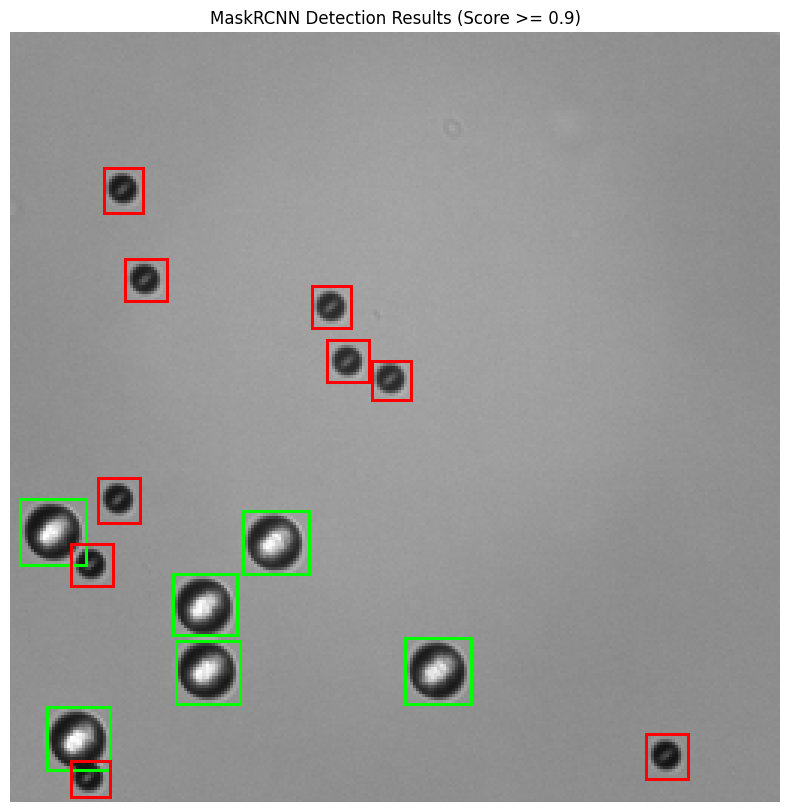

In [15]:
"""
#############################
#   COMPLETE THIS SECTION!  #
#############################
Task: display bounding boxes on image using helper.draw_boxes_labels().
      - live = green, dead = red
      - only draw boxes with score >= 0.9
"""
from helper import draw_boxes_labels

# Filter predictions with score >= 0.9
score_threshold = 0.9
high_score_mask = scores >= score_threshold

filtered_boxes = boxes[high_score_mask]
filtered_labels = labels[high_score_mask]
filtered_scores = scores[high_score_mask]

print(f"Showing {len(filtered_boxes)} detections with score >= {score_threshold}")
print(f"Filtered scores: {filtered_scores}")
print(f"Filtered labels: {filtered_labels}")

# Define colors: live (label 1) = green, dead (label 2) = red
label_colors = [
    (0, 255, 0),    # Green for live beads (label 1)
    (255, 0, 0)     # Red for dead beads (label 2)
]

# Draw bounding boxes on the image
show_image = draw_boxes_labels(image, filtered_boxes, filtered_labels, label_colors)

plt.figure(figsize=(10, 10))
plt.imshow(show_image.transpose(1, 2, 0))
plt.title(f'MaskRCNN Detection Results (Score >= {score_threshold})')
plt.axis('off')
plt.show()